## `ConvLSTM` (`one-shot`) Inference 
* the aim of this notebook is to run inference on trained `ConvLSTM()` models that predict the entire target sequence in one pass.

In [1]:
import os
from pathlib import Path
from typing import Dict, Tuple, Any

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import io
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from rainnow.src.conv_lstm_utils import IMERGDataset, plot_predicted_sequence
from rainnow.src.models.conv_lstm import ConvLSTMModel
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config
from rainnow.src.utilities.utils import get_device, transform_minus1_1_to_0_1

In [2]:
# ** plotting helpers **
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
# cmap = io.loadmat("/teamspace/studios/this_studio/irp-ds423/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# ** get device **
device = get_device()

No GPU available! (device = cpu)


#### `Datasets & Dataloaders`

In [3]:
# ** DIR helpers **
CKPT_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/results/"
CONFIGS_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/src/dyffusion/configs/"
# CKPT_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/results/"
# CONFIGS_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# ** Dataloader Params **
BATCH_SIZE = 4
NUM_WORKERS = 0

INPUT_SEQUENCE_LENGTH = 8
OUTPUT_SEQUENCE_LENGTH = 8

In [5]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],
        "window": 1,
        "horizon": 15,
        "prediction_horizon": 15,
        "sequence_dt": 1,
    },
)

# get the .data_<split>
datamodule.setup("validate")
datamodule.setup("test")
datamodule.setup("predict")

[2024-08-25 10:13:09][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-25 10:13:09][imerg_precipitation.py][INFO] --> validate data split: [202301010000, 202307010000]
[2024-08-25 10:17:50][torch_datasets.py][INFO] --> creating VAL tensor dataset.
[2024-08-25 10:17:50][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-25 10:17:50][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-25 10:17:50][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-08-25 10:22:34][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-08-25 10:22:34][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-25 10:22:35][abstract_datamodule.py][INFO] -->  Dataset test size: 507
[2024-08-25 10:22:35][i

In [6]:
# create the datasets.
val_dataset = IMERGDataset(
    datamodule, "validate", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
test_dataset = IMERGDataset(
    datamodule, "test", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
predict_dataset = IMERGDataset(
    datamodule, "predict", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)

# instantiate the dataloaders.
val_loader = DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)
predict_loader = DataLoader(
    dataset=predict_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

In [7]:
# ** instantiate the preprocesser obj **
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-25 10:27:19][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


#### `Instantiate a ConvLSTM()`

In [8]:
ckpt_ids = {
    # entire sequence in one go ConvLSTM.
    "convlstm-r9m0o2ho": "I8:T8 | hs=(64, 64), ks=(5, 5), dp=.3 [40E, lr=3e-4]",
    "convlstm-jtwm5nt0": "I8:T8 | hs=(64, 64, 64), ks=(5, 5), dp=.3 [40E, lr=3e-4]",
    "convlstm-evzddqer": "I8:T8 | hs=(32, 32, 32), ks=(5, 5), dp=.3 [40E, lr=1e-4]",
    "convlstm-5tbjfvkc": "I8:T8 | hs=(128, 64), ks=(3, 3), dp=.15 [20E, lr=3e-4]",
    "convlstm-3bg6j99s": "I8:T8 | hs=(128, 64), ks=(5, 5), dp=.3 [20E, lr=3e-4]",
    "convlstm-ivqxk14e": "I8:T8 | hs=(128, 64), ks=(5, 5), dp=.15 [20E, lr=3e-4]",
}

In [67]:
# ** load in checkpoint **
ckpt_id = "convlstm-jtwm5nt0"

model_save_path = Path(
    os.path.join(CKPT_BASE_PATH, "convlstm_experiments", ckpt_id, "checkpoints", f"{ckpt_id}.pt")
)

In [68]:
# ** instantiate a new model **

KERNEL_SIZE = (5, 5)
INPUT_DIMS = (1, 128, 128)  # C, H, W
OUTPUT_CHANNELS = 1
HIDDEN_CHANNELS = [64, 64, 64]
NUM_LAYERS = 3
CELL_DROPOUT = 0.15
OUTPUT_ACTIVATION = nn.Sigmoid()

model = ConvLSTMModel(
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    input_dims=INPUT_DIMS,
    hidden_channels=HIDDEN_CHANNELS,
    output_channels=OUTPUT_CHANNELS,
    num_layers=NUM_LAYERS,
    kernel_size=KERNEL_SIZE,
    output_activation=OUTPUT_ACTIVATION,
    apply_batchnorm=True,
    cell_dropout=CELL_DROPOUT,
    bias=True,
    device=device,
)

model = model.to(device)

# load in the checkpoint.
model.load_state_dict(
    state_dict=torch.load(model_save_path, map_location=torch.device(device))["model_state_dict"]
)
# set model into eval mode.
model.eval()

ConvLSTMModel(
  (output_activation): Sigmoid()
  (convlstm): ConvLSTM(
    (output_activation): Sigmoid()
    (conv_lstm_cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv_input_and_hidden_to_cell): Sequential(
          (0): Conv2d(65, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout(p=0.15, inplace=False)
        )
      )
      (1-2): 2 x ConvLSTMCell(
        (conv_input_and_hidden_to_cell): Sequential(
          (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Dropout(p=0.15, inplace=False)
        )
      )
    )
    (conv_hidden_to_output): Sequential(
      (0): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): Sigmoid()
    )
  )
)

#### `Get inputs, X and predict.`

In [69]:
iter_loader = iter(predict_loader)
X, target = next(iter_loader)

# get raw scale.
X_reversed = pprocessor.reverse_processing(X).cpu().detach()
target_reversed = pprocessor.reverse_processing(target).cpu().detach()

In [70]:
# ** make prediction **
pred = model(X.to(device))
if isinstance(model.output_activation, nn.Tanh):
    yhat = transform_minus1_1_to_0_1(pred)

pred_reversed = pprocessor.reverse_processing(pred)
pred_reversed = pred_reversed.cpu().detach()

In [75]:
# ** plot params **
b = 3
plot_params = {"cmap": rain_cmap, "vmin": 0.5, "vmax": 8}
figsize = (20, 3)

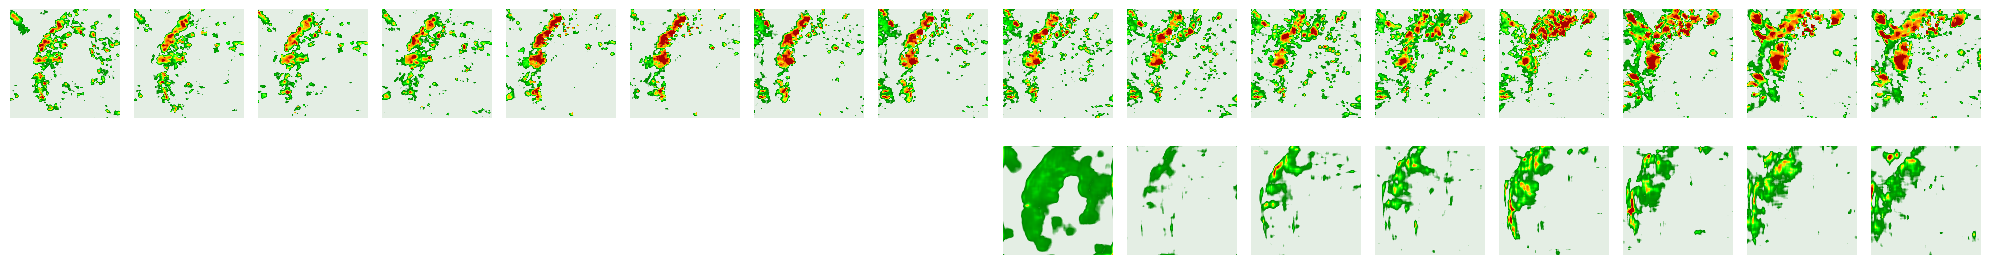

In [76]:
plot_predicted_sequence(
    X=X_reversed,
    target=target_reversed,
    pred=pred_reversed,
    batch_num=b,
    plot_params=plot_params,
    figsize=figsize,
)

### END OF SCRIPT.